In [1]:
import os
import re
import pandas as pd

folder_path = r"C:\Users\austi\OneDrive\CSE 5245 NetwSci\Project\Attention Graphs"

metrics = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector', 'Clustering', 'Pagerank']

def parse_overlap_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    metric_data = {}
    current_metric = None

    for line in lines:
        line = line.strip()
        for metric in metrics:
            if line.startswith(f"- {metric}:"):
                current_metric = metric
                metric_data[current_metric] = {}
        if "Overlapping Nodes:" in line and current_metric:
            overlap_count = int(re.search(r"Overlapping Nodes: (\d+)", line).group(1))
            metric_data[current_metric]["Overlapping"] = overlap_count

    file_name = os.path.basename(file_path).replace("_topk_overlap.txt", "")
    dataset, model = file_name.split("_", 1)

    result = {
        "Dataset": dataset,
        "Model": model
    }
    for metric in metrics:
        result[metric] = metric_data.get(metric, {}).get("Overlapping", 0)

    return result

data = []
for filename in os.listdir(folder_path):
    if filename.endswith("_topk_overlap.txt"):
        full_path = os.path.join(folder_path, filename)
        data.append(parse_overlap_file(full_path))

df_overlap = pd.DataFrame(data)

df_overlap = df_overlap.sort_values(by=["Dataset", "Model"]).reset_index(drop=True)

print(df_overlap)


      Dataset         Model  Degree  Betweenness  Closeness  Eigenvector  \
0   Chameleon  dt2_avg_1L2H       4            4          0            6   
1   Chameleon  dt2_avg_2L2H      11            5          0            4   
2   Chameleon   dt_avg_1L2H      39           30         17           17   
3   Chameleon   dt_avg_2L2H      48           38         16           23   
4    Citeseer  dt2_avg_1L2H       6            2          9            7   
5    Citeseer  dt2_avg_2L2H       3            3          5            5   
6    Citeseer   dt_avg_1L2H      32           32         14           23   
7    Citeseer   dt_avg_2L2H      76           69         44           43   
8        Cora  dt2_avg_1L2H       7            2          3            7   
9        Cora  dt2_avg_2L2H       3            3          2            5   
10       Cora   dt_avg_1L2H      52           47         20           28   
11       Cora   dt_avg_2L2H      92           72         38           31   

    Cluster

In [2]:
df_overlap["Mean Centrality"] = df_overlap[["Degree", "Betweenness", "Closeness", "Eigenvector", "Clustering", "Pagerank"]].mean(axis=1)


In [13]:
df_overlap.groupby("Model")[["Degree", "Betweenness", "Closeness", "Eigenvector", "Clustering", "Pagerank","Mean Centrality"]].mean()


,Degree,Betweenness,Closeness,Eigenvector,Clustering,Pagerank,Mean Centrality
Model,,,,,,,
dt2_avg_1L2H,5.666667,2.666667,4.000000,6.666667,3.666667,5.666667,4.722222
dt2_avg_2L2H,5.666667,3.666667,2.333333,4.666667,2.666667,4.333333,3.888889
dt_avg_1L2H,41.000000,36.333333,17.000000,22.666667,16.333333,25.666667,26.500000
dt_avg_2L2H,72.000000,59.666667,32.666667,32.333333,60.333333,42.000000,49.833333


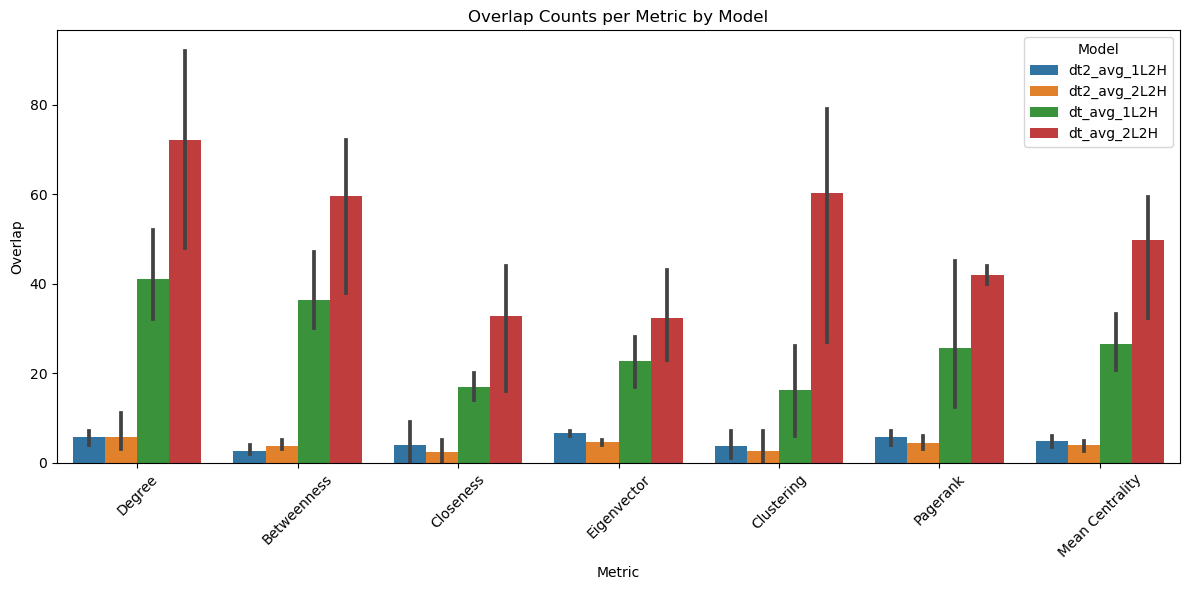

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = df_overlap.melt(id_vars=["Dataset", "Model"], var_name="Metric", value_name="Overlap")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x="Metric", y="Overlap", hue="Model")
plt.title("Overlap Counts per Metric by Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


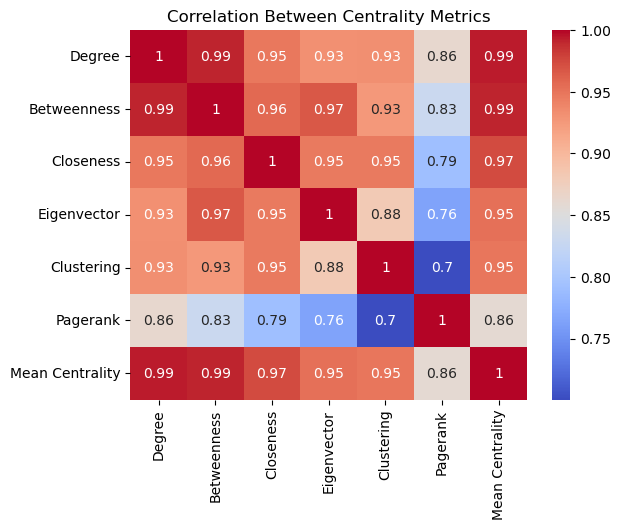

In [20]:
corr_matrix = df_overlap[["Degree", "Betweenness", "Closeness", "Eigenvector", "Clustering", "Pagerank","Mean Centrality"]].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Centrality Metrics")
plt.show()


In [21]:
df_overlap["MeanOverlap"] = df_overlap[
    ["Degree", "Betweenness", "Closeness", "Eigenvector", "Clustering", "Pagerank","Mean Centrality"]
].mean(axis=1)

top_models = df_overlap.sort_values("MeanOverlap", ascending=False)
print(top_models[["Dataset", "Model", "MeanOverlap"]].head())


      Dataset        Model  MeanOverlap
11       Cora  dt_avg_2L2H    59.333333
7    Citeseer  dt_avg_2L2H    57.833333
10       Cora  dt_avg_1L2H    33.166667
3   Chameleon  dt_avg_2L2H    32.333333
2   Chameleon  dt_avg_1L2H    25.666667


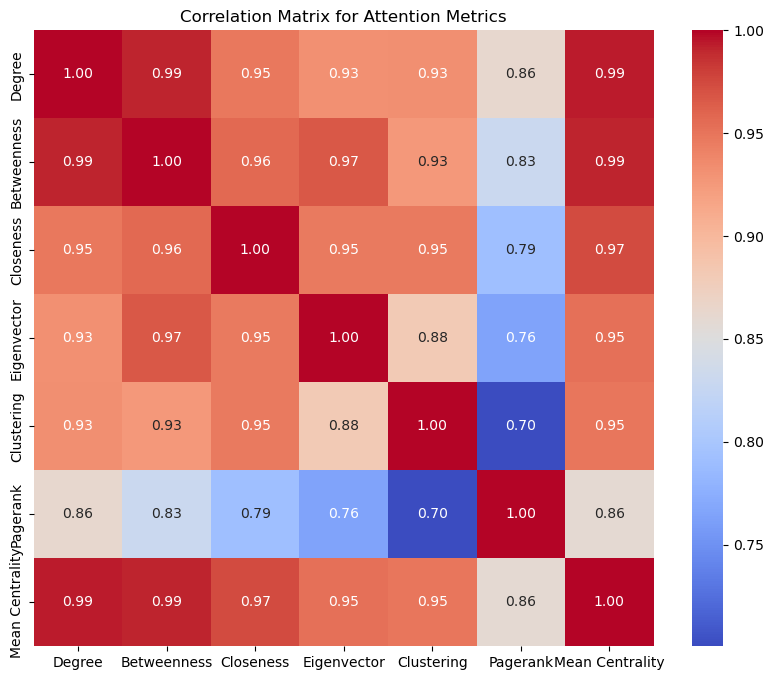

In [22]:

corr_matrix = df_overlap[["Degree", "Betweenness", "Closeness", "Eigenvector", "Clustering", "Pagerank","Mean Centrality"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Attention Metrics")
plt.show()

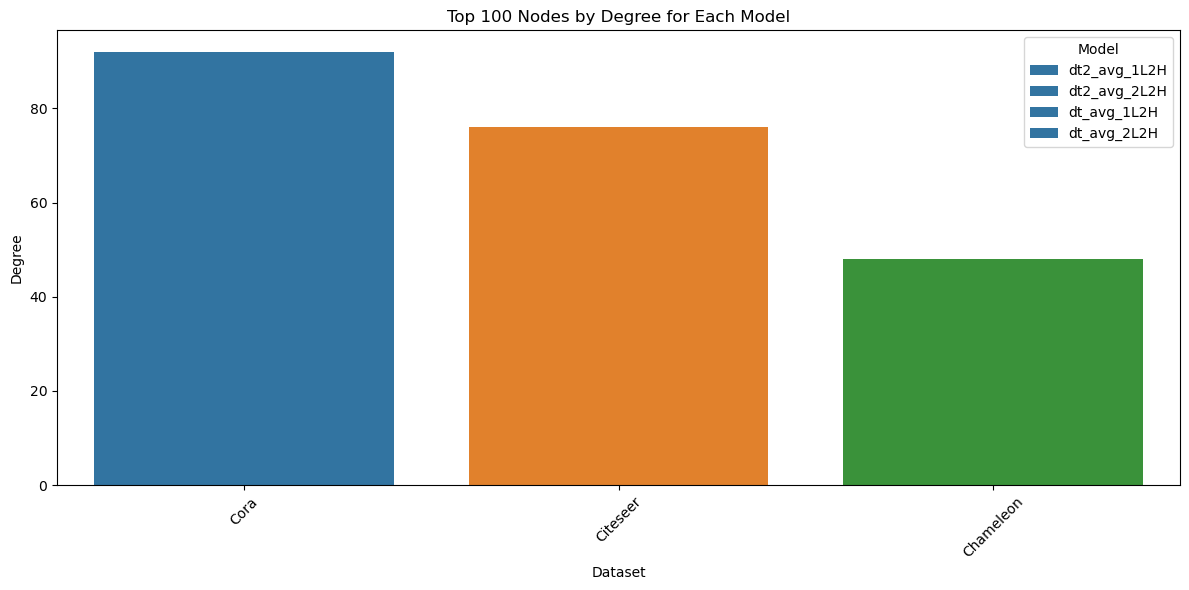

In [8]:

top_nodes_per_model = {}
for model in df_overlap['Model'].unique():
    top_nodes = df_overlap[df_overlap['Model'] == model].nlargest(100, 'Degree')
    top_nodes_per_model[model] = top_nodes[['Dataset', 'Model', 'Degree']]

plt.figure(figsize=(12, 6))
for model, top_nodes in top_nodes_per_model.items():
    sns.barplot(x="Dataset", y="Degree", data=top_nodes, label=model)

plt.title("Top 100 Nodes by Degree for Each Model")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

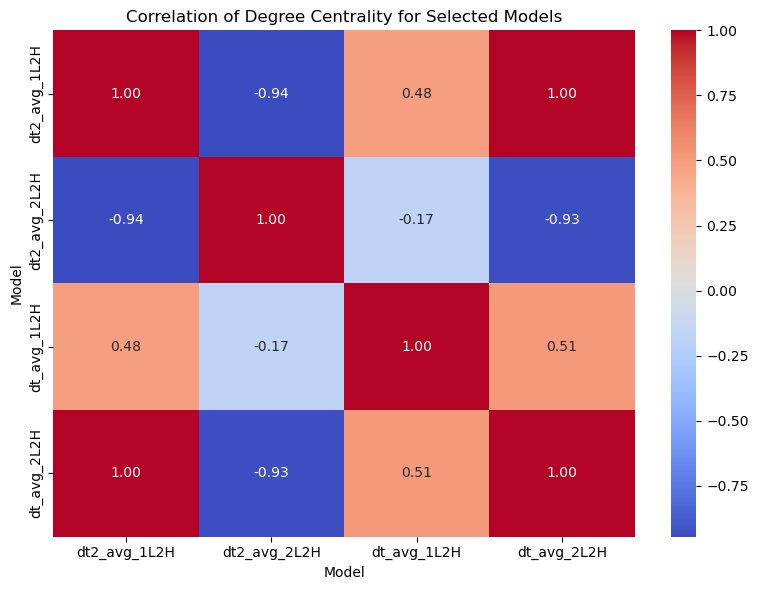

In [9]:
specific_models = ['dt_avg_1L2H', 'dt2_avg_1L2H', 'dt_avg_2L2H', 'dt2_avg_2L2H']

df_specific = df_overlap[df_overlap['Model'].isin(specific_models)]

pivot_specific = df_specific.pivot(index='Dataset', columns='Model', values='Degree')

model_specific_corr = pivot_specific.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(model_specific_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Degree Centrality for Selected Models")
plt.tight_layout()
plt.show()


In [10]:
summary_stats = df_overlap.describe()
print(summary_stats)


          Degree  Betweenness  Closeness  Eigenvector  Clustering   Pagerank  \
count  12.000000    12.000000  12.000000    12.000000   12.000000  12.000000   
mean   31.083333    25.583333  14.000000    16.583333   20.750000  19.416667   
std    30.805721    26.517433  14.422205    12.936617   27.860448  18.277947   
min     3.000000     2.000000   0.000000     4.000000    0.000000   3.000000   
25%     5.500000     3.000000   2.750000     5.750000    2.500000   5.500000   
50%    21.500000    17.500000  11.500000    12.000000    7.000000   6.500000   
75%    49.000000    40.250000  17.750000    24.250000   26.250000  40.500000   
max    92.000000    72.000000  44.000000    43.000000   79.000000  45.000000   

       Mean Centrality  MeanOverlap  
count        12.000000    12.000000  
mean         21.236111    21.236111  
std          20.898197    20.898197  
min           2.666667     2.666667  
25%           4.500000     4.500000  
50%          13.250000    13.250000  
75%          

In [11]:
top_models_degree = df_overlap.sort_values(by="Degree", ascending=False).head(3)
print(top_models_degree[["Dataset", "Model", "Degree"]])


     Dataset        Model  Degree
11      Cora  dt_avg_2L2H      92
7   Citeseer  dt_avg_2L2H      76
10      Cora  dt_avg_1L2H      52


C:\Users\austi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\austi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


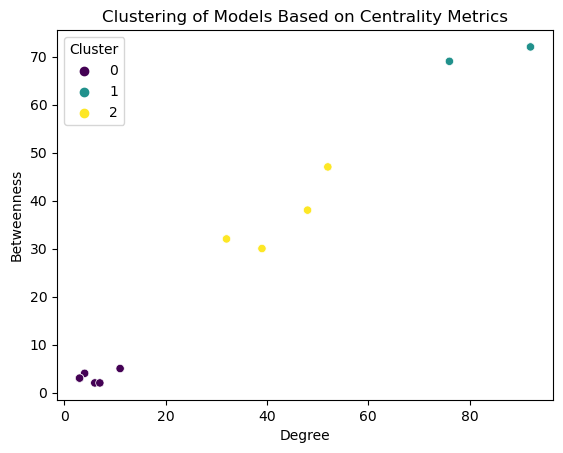

In [12]:
from sklearn.cluster import KMeans

metrics_data = df_overlap[["Degree", "Betweenness", "Closeness", "Eigenvector", "Clustering", "Pagerank"]].values

kmeans = KMeans(n_clusters=3, random_state=42)
df_overlap['Cluster'] = kmeans.fit_predict(metrics_data)

sns.scatterplot(data=df_overlap, x="Degree", y="Betweenness", hue="Cluster", palette="viridis")
plt.title("Clustering of Models Based on Centrality Metrics")
plt.show()


In [16]:
summary_stats = df_overlap.groupby(["Dataset", "Model"]).agg(
    mean_degree=("Degree", "mean"),
    mean_betweenness=("Betweenness", "mean"),
    mean_closeness=("Closeness", "mean"),
    mean_eigenvector=("Eigenvector", "mean"),
    mean_clustering=("Clustering", "mean"),
    mean_pagerank=("Pagerank", "mean"),
    
    std_degree=("Degree", "std"),
    std_betweenness=("Betweenness", "std"),
    std_closeness=("Closeness", "std"),
    std_eigenvector=("Eigenvector", "std"),
    std_clustering=("Clustering", "std"),
    std_pagerank=("Pagerank", "std"),
    
    median_degree=("Degree", "median"),
    median_betweenness=("Betweenness", "median"),
    median_closeness=("Closeness", "median"),
    median_eigenvector=("Eigenvector", "median"),
    median_clustering=("Clustering", "median"),
    median_pagerank=("Pagerank", "median"),
)

print(summary_stats)


                        mean_degree  mean_betweenness  mean_closeness  \
Dataset   Model                                                         
Chameleon dt2_avg_1L2H          4.0               4.0             0.0   
          dt2_avg_2L2H         11.0               5.0             0.0   
          dt_avg_1L2H          39.0              30.0            17.0   
          dt_avg_2L2H          48.0              38.0            16.0   
Citeseer  dt2_avg_1L2H          6.0               2.0             9.0   
          dt2_avg_2L2H          3.0               3.0             5.0   
          dt_avg_1L2H          32.0              32.0            14.0   
          dt_avg_2L2H          76.0              69.0            44.0   
Cora      dt2_avg_1L2H          7.0               2.0             3.0   
          dt2_avg_2L2H          3.0               3.0             2.0   
          dt_avg_1L2H          52.0              47.0            20.0   
          dt_avg_2L2H          92.0              72

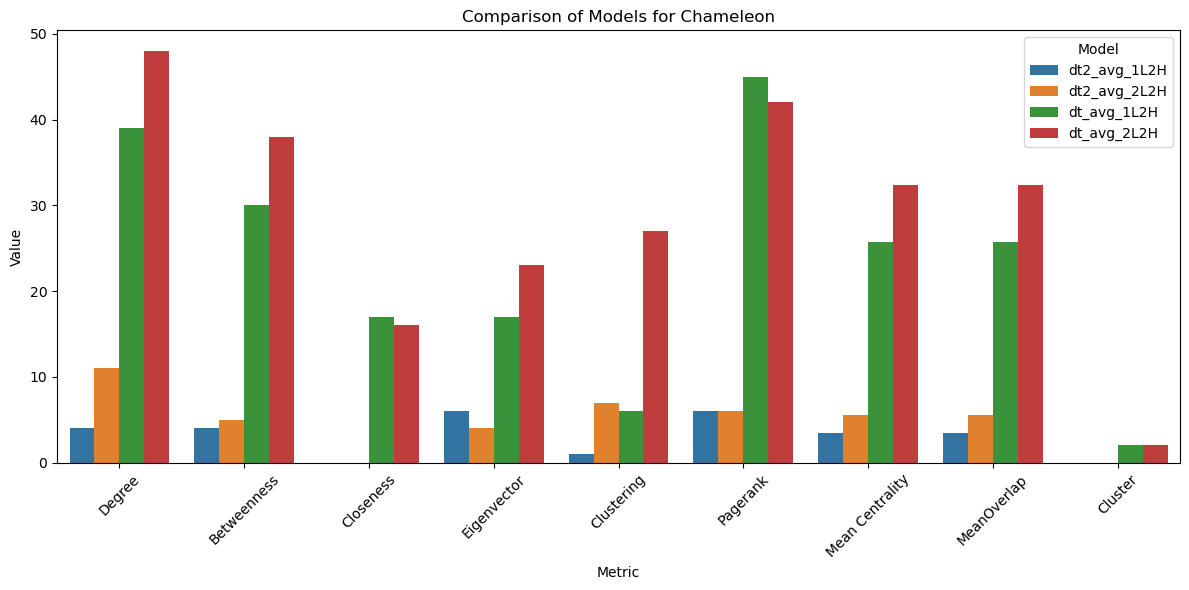

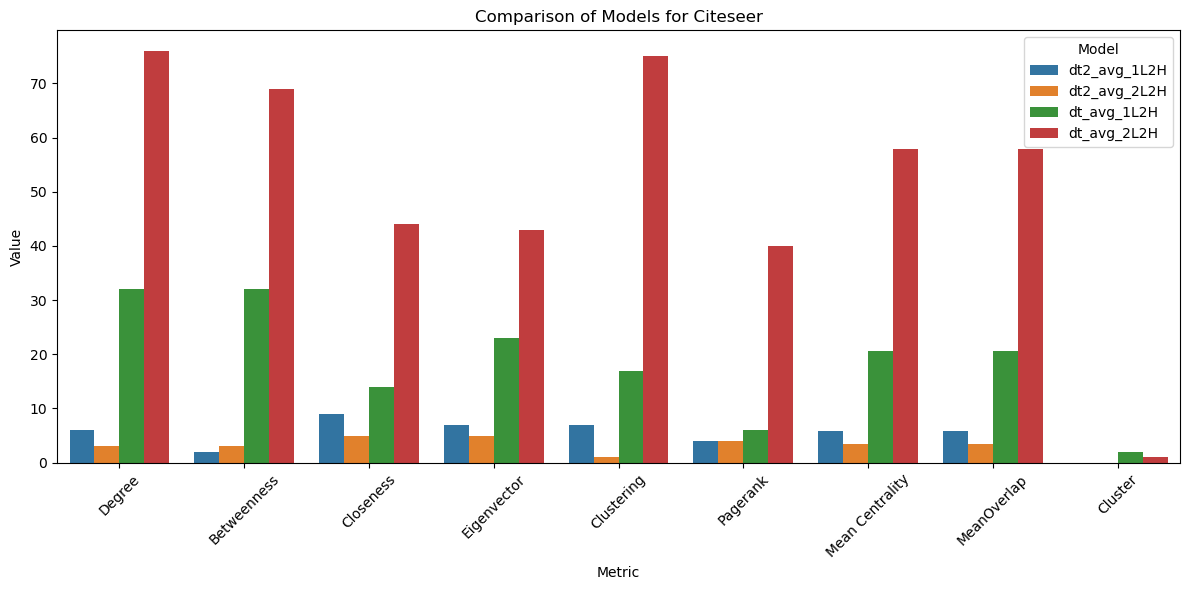

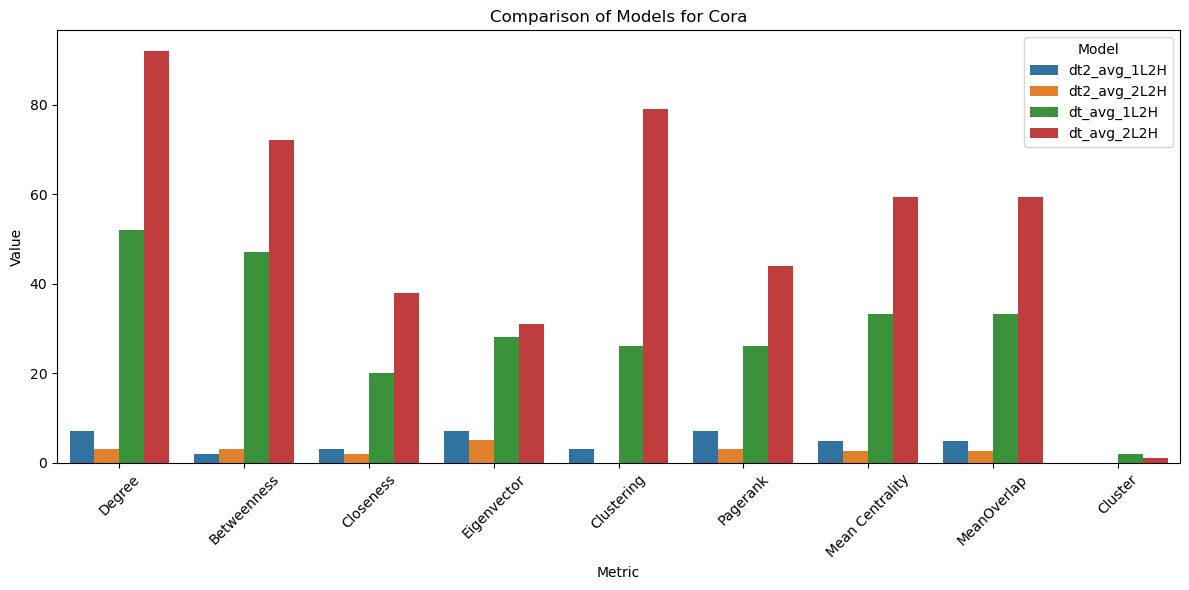

In [15]:
def compare_models_per_dataset(dataset_name):
    df_filtered = df_overlap[df_overlap["Dataset"] == dataset_name]
    
    df_melted = df_filtered.melt(id_vars=["Dataset", "Model"], var_name="Metric", value_name="Value")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x="Metric", y="Value", hue="Model")
    plt.title(f"Comparison of Models for {dataset_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

compare_models_per_dataset("Chameleon")
compare_models_per_dataset("Citeseer")
compare_models_per_dataset("Cora")


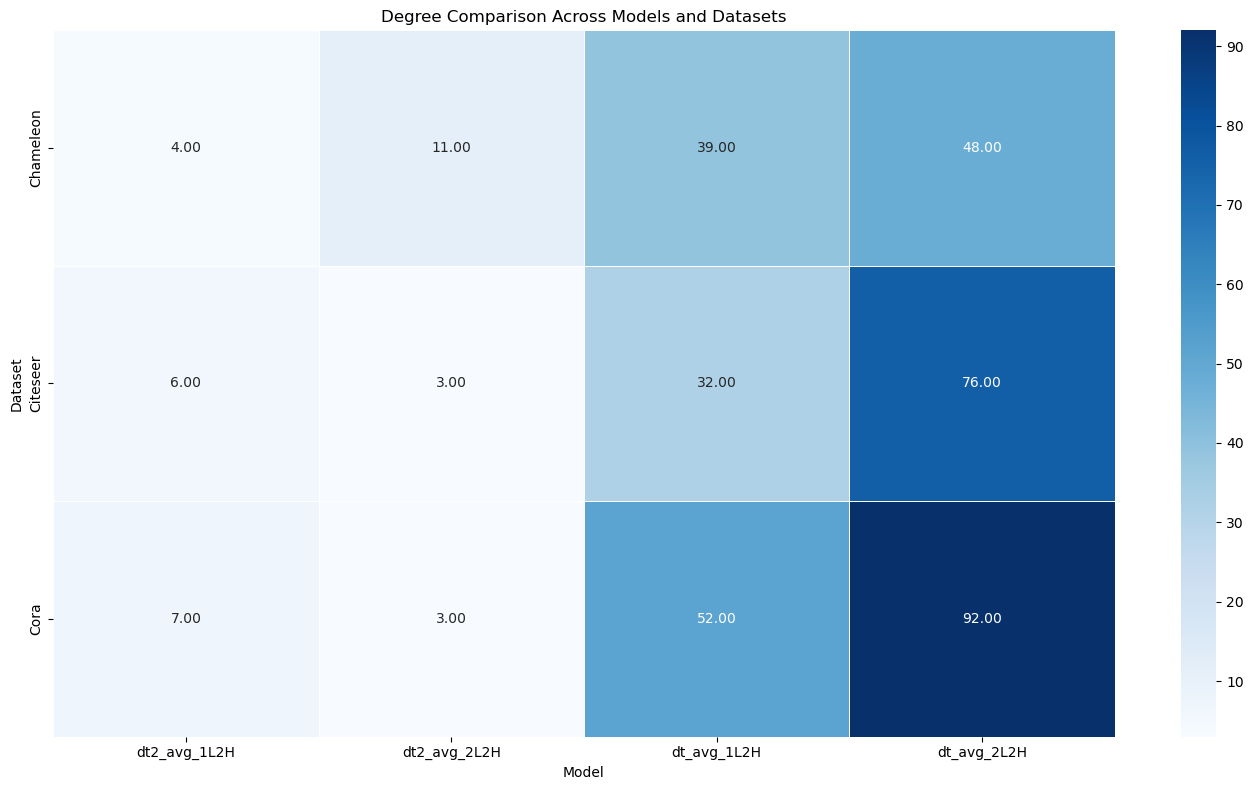

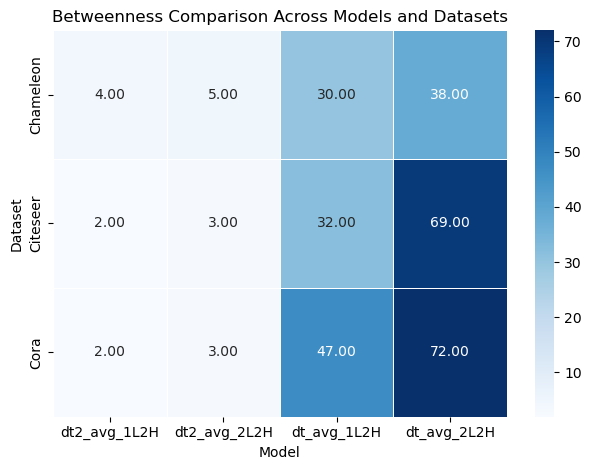

In [17]:
pivot_df = df_overlap.pivot(index="Dataset", columns="Model", values=["Degree", "Betweenness", "Closeness", "Eigenvector", "Clustering", "Pagerank"])

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df["Degree"], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Degree Comparison Across Models and Datasets")
plt.tight_layout()
plt.show()

sns.heatmap(pivot_df["Betweenness"], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Betweenness Comparison Across Models and Datasets")
plt.tight_layout()
plt.show()


In [26]:
folder_path = r"C:\Users\austi\OneDrive\CSE 5245 NetwSci\Project\Attention Graphs"

metrics = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector', 'Clustering', 'Pagerank']

def parse_overlap_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    metric_data = {}
    current_metric = None

    for line in lines:
        line = line.strip()
        
        for metric in metrics:
            if line.startswith(f"- {metric}:"):
                current_metric = metric
                metric_data[current_metric] = {}

        if "Overlapping Nodes:" in line and current_metric:
            overlap_count = int(re.search(r"Overlapping Nodes: (\d+)", line).group(1))
            metric_data[current_metric]["Overlapping"] = overlap_count
        
        if "Sample Nodes:" in line and current_metric:
            node_match = re.search(r"Sample Nodes: \[([^\]]+)\]", line)
            if node_match:
                nodes = node_match.group(1).split(", ")
                metric_data[current_metric]["Nodes"] = nodes

    file_name = os.path.basename(file_path).replace("_topk_overlap.txt", "")
    dataset, model = file_name.split("_", 1)

    result = {
        "Dataset": dataset,
        "Model": model
    }

    for metric in metrics:
        result[metric] = metric_data.get(metric, {}).get("Overlapping", 0)
        result[f"{metric}_Nodes"] = metric_data.get(metric, {}).get("Nodes", [])

    return result

data = []
for filename in os.listdir(folder_path):
    if filename.endswith("_topk_overlap.txt"):
        full_path = os.path.join(folder_path, filename)
        data.append(parse_overlap_file(full_path))

df_overlap = pd.DataFrame(data)

df_overlap = df_overlap.sort_values(by=["Dataset", "Model"]).reset_index(drop=True)

print(df_overlap)


      Dataset         Model  Degree  \
0   Chameleon  dt2_avg_1L2H       4   
1   Chameleon  dt2_avg_2L2H      11   
2   Chameleon   dt_avg_1L2H      39   
3   Chameleon   dt_avg_2L2H      48   
4    Citeseer  dt2_avg_1L2H       6   
5    Citeseer  dt2_avg_2L2H       3   
6    Citeseer   dt_avg_1L2H      32   
7    Citeseer   dt_avg_2L2H      76   
8        Cora  dt2_avg_1L2H       7   
9        Cora  dt2_avg_2L2H       3   
10       Cora   dt_avg_1L2H      52   
11       Cora   dt_avg_2L2H      92   

                                         Degree_Nodes  Betweenness  \
0                              [921, 956, 1875, 2212]            4   
1   [531, 921, 1288, 1714, 1814, 1875, 2030, 2177,...            5   
2   [141, 531, 652, 760, 829, 890, 921, 956, 1187,...           30   
3   [141, 276, 652, 760, 829, 890, 904, 921, 956, ...           38   
4                    [254, 314, 616, 624, 2404, 3046]            2   
5                                     [254, 624, 670]            3   
6 

In [34]:
import ast
import re
from collections import Counter
import pandas as pd


def parse_nodes(x):
    if isinstance(x, list):  # If x is already a list
        return set(map(int, x))  # Convert directly to a set of integers
    # If x is a string, proceed with cleaning
    elif isinstance(x, str):
        # Remove unwanted characters and ensure a valid list format
        x = re.sub(r"[^\d,\[\]\s]", "", x)  # Clean up any characters that might cause issues

        # Only proceed if the string is not empty or an invalid list
        if x != '[]' and x != '':
            try:
                # Safely evaluate the string to a list of integers
                node_list = ast.literal_eval(x)
                return set(map(int, node_list))  # Convert to a set of integers
            except Exception as e:
                print(f"Error parsing: {x}. Error: {e}")
                return set()  # Return an empty set in case of an error
    return set()


if 'Degree_Nodes' in df_overlap.columns and \
   'Betweenness_Nodes' in df_overlap.columns and \
   'Closeness_Nodes' in df_overlap.columns and \
   'Eigenvector_Nodes' in df_overlap.columns and \
   'Clustering_Nodes' in df_overlap.columns and \
   'Pagerank_Nodes' in df_overlap.columns:

    # Extract the nodes for each metric and apply the parsing function
    degree_nodes = df_overlap["Degree_Nodes"].apply(parse_nodes)
    betweenness_nodes = df_overlap["Betweenness_Nodes"].apply(parse_nodes)
    closeness_nodes = df_overlap["Closeness_Nodes"].apply(parse_nodes)
    eigenvector_nodes = df_overlap["Eigenvector_Nodes"].apply(parse_nodes)
    clustering_nodes = df_overlap["Clustering_Nodes"].apply(parse_nodes)
    pagerank_nodes = df_overlap["Pagerank_Nodes"].apply(parse_nodes)

    all_nodes_per_row = []
    for index, row in df_overlap.iterrows():
        combined_nodes = set()
        if 'Degree_Nodes' in row:
            combined_nodes.update(parse_nodes(row['Degree_Nodes']))
        if 'Betweenness_Nodes' in row:
            combined_nodes.update(parse_nodes(row['Betweenness_Nodes']))
        if 'Closeness_Nodes' in row:
            combined_nodes.update(parse_nodes(row['Closeness_Nodes']))
        if 'Eigenvector_Nodes' in row:
            combined_nodes.update(parse_nodes(row['Eigenvector_Nodes']))
        if 'Clustering_Nodes' in row:
            combined_nodes.update(parse_nodes(row['Clustering_Nodes']))
        if 'Pagerank_Nodes' in row:
            combined_nodes.update(parse_nodes(row['Pagerank_Nodes']))
        all_nodes_per_row.extend(list(combined_nodes))

    node_counts = Counter(all_nodes_per_row)

    top_nodes = node_counts.most_common(10)

    print("Top 10 nodes that appear in the top nodes of multiple metrics across all datasets and models:")
    for node, count in top_nodes:
        print(f"Node {node}: {count} times")

else:
    print("Error: One or more of the required '_Nodes' columns are missing in the DataFrame.")

Top 10 nodes that appear in the top nodes of multiple metrics across all datasets and models:
Node 154: 5 times
Node 921: 4 times
Node 373: 4 times
Node 254: 4 times
Node 97: 4 times
Node 156: 4 times
Node 357: 4 times
Node 8: 3 times
Node 1875: 3 times
Node 531: 3 times
